# Setting Up

In [1]:
!nvidia-smi

Tue Aug 22 08:09:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
bs = 2
seed = 42

In [3]:
! pip install -q transformers[sentencepiece] bert_score sacrebleu fastai ohmeow-blurr datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
import transformers
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *
from datasets import load_dataset

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


# Data

In [5]:
dataset = load_dataset("ccdv/cnn_dailymail", "3.0.0", split="train[:2000]")
cnndm_df = pd.DataFrame(dataset)
cnndm_df.head()

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,"Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found. It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year. He is among several hundred GSA ""virtual"" workers who also travel to various conferences and their home offices, costing the agency millions of dollars over the past three years. Under the program, ...","The employee in agency's Kansas City office is among hundreds of ""virtual"" workers .\nThe employee's travel to and from the mainland U.S. last year cost more than $24,000 .\nThe telecommuting program, like all GSA practices, is under review .",00027e965c8264c35cc1bc55556db388da82b07f
3,"Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him as part of a team of doctors. Dr. Blaga Stancheva, a family physician and specialist in obstetrics, said both Burkhart and his mother, Dorothee, were her patients in Vancouver while both were applying for refugee status in Canada. ""I was asked to diagnose and treat Harry to support a claim explaining why he was unable to show up in a small-claims court case,"" Stancheva told CNN in a phone intervie...","NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: ""autism, severe anxiety, post-traumatic stress disorder and depression""\nBurkhart is also suspected in a German arson probe, officials say .\nProsecutors believe the German national set a string of fires in Los Angeles .",0002c17436637c4fe1837c935c04de47adb18e9a
4,"(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jose Carlos Montano, 18, was arrested on charges of felony rape, rape in concert with force, and penetration with a foreign object, said Richmond Police L

In [6]:
from transformers import BartForConditionalGeneration

pretrained_model_name = "sshleifer/distilbart-cnn-6-6"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [7]:
batch_tokenize_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch,
    hf_config,
    hf_tokenizer,
    hf_model,
    max_length=256,
    max_target_length=130
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader("article"), get_y=ColReader("highlights"), splitter=RandomSplitter())

In [8]:
dls = dblock.dataloaders(cnndm_df, bs=4)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [9]:
dls.show_batch(dataloaders=dls, max_n=4)

,text,target
0,"<s> While Iraq's military claimed Wednesday to have driven back militants battling for control of the country, the chairman of the Joint Chiefs of Staff told Congress that the United States has received a request from the Iraqi government to use its air power in the conflict. Gen. Martin Dempsey, the senior ranking member of the U.S. armed forces, spoke before the Senate Appropriations Committee Wednesday on Capitol Hill in Washington, saying that the United States' ""national security interest (is) to counter (ISIS) where we find them."" ISIS is the Islamic State in Iraq and Syria. Comprising mostly Sunni Muslims, ISIS is an al Qaeda splinter group that wants to establish a caliphate, or Islamic state, that would stretch from Iraq into northern Syria. The group has had substantial success in Syria battling Syrian President Bashar al-Assad's security forces. Since launching their offensive in Iraq, ISIS claims to have killed at least 1,700 Shiites. Hundreds of thousands of Iraqis have fled, prompting fears of a brewing humanitarian crisis. Qassim Atta, a spokesman for Iraqi security forces, on Wednesday night said an investigation had been ordered into 59 high-ranking security officials accused of leaving their posts. The officials could be executed if found guilty, Atta said. Concerns over</s>","Vice President Biden stresses need for national unity in talk with Iraqi PM.\nA cleric called for attacks against U.S. embassies in the case of airstrikes.\nInvestigation will probe Iraqi security forces who left posts, general commander says.\nSaudi Arabia responds to Iraq's accusation that it's helping ISIS, calling allegation a ""falsehood"""
1,"<s> London (CNN) -- As tens of thousands of athletes, team officials and visitors gather in London ahead of the Olympic opening ceremony on Friday, security is paramount for the Games organizers and British authorities. And perhaps the biggest headache of all is the challenge of safeguarding the more than 100 heads of state and foreign dignitaries who will attend the opening ceremony at the Olympic Park -- Queen Elizabeth II, first lady Michelle Obama and U.S. presidential hopeful Mitt Romney among them. But should visitors and competitors be worried? Security concerns hit the headlines this month when it emerged that private security contractor G4S, which was supposed to have provided 10,400 guards for the Olympics and Paralympics, would not be able to deliver. As a result, the government is deploying 18,200 troops -- many more than planned and almost twice as many as are in Afghanistan -- in order to remedy the shortfall. About 1,200 of those were called up just this week after being placed on standby. Nonetheless, Culture Secretary Jeremy Hunt, the minister responsible for the Games, said Tuesday that the government ""continues to have every confidence that we will deliver a safe and secure Games."" The decision to call up the extra troops was down to ministers' determination to ""leave nothing to chance</s>","The government is deploying 18,200 troops to make up for a shortfall in security guards.\nOne headache is safeguarding more than 100 visiting heads of state and foreign dignitaries.\nPrivate security contractor G4S has failed to recruit and accredit enough security staff.\nFighter jets are on standby, and a helicopter carrier is moored in the Thames."
2,"<s> Washington (CNN) -- New details emerged of what the White House knew about the Internal Revenue Service targeting of conservative groups, with spokesman Jay Carney disclosing Chief of Staff Denis McDonough was among the top officials made aware of the matter late last month. In a new timeline provided by Carney to reporters on Monday, General Counsel Kathryn Ruemmler learned on April 24 of a pending Treasury inspector general's report on how IRS staff used criteria targeting conservative groups in assessing eligibility for tax-exempt status. According to Carney, Ruemmler told McDonough as well as other Treasury 

# Training

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
seq2seq_metrics = {
    "rouge": {
        "compute_kwargs": {"rouge_types": ["rouge1", "rouge2", "rougeL", "rougeLsum"], "use_stemmer": True},
        "returns": ["rouge1", "rouge2", "rougeL", "rougeLsum"],
    },
    "bertscore": {"compute_kwargs": {"lang": "en"}, "returns": ["precision", "recall", "f1"]},
}

In [12]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

# Stage - 0

In [13]:
learn.freeze()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


SuggestedLRs(minimum=4.786300996784121e-05, steep=6.309573450380412e-07, valley=9.120108734350652e-05, slide=2.0892961401841603e-05)

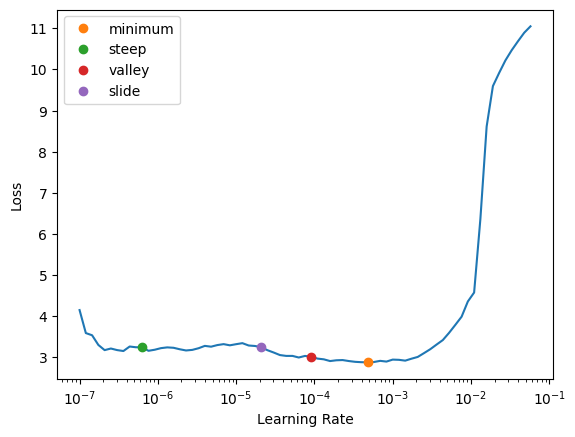

In [14]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [15]:
learn.fit_one_cycle(1, lr_max=7.5e-6, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,time
0,2.292361,2.115483,0.375318,0.161924,0.260201,0.349102,0.874204,0.886456,0.880204,04:40


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [16]:
learn.save("news_summarizer")

Path('models/news_summarizer.pth')

In [17]:
learn.metrics = None
learn.export("news_summarizer.pkl")

# Stage - 1

In [18]:
learn.unfreeze()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


SuggestedLRs(minimum=7.585775847473997e-08, steep=1.0964781722577754e-06, valley=3.630780702224001e-05, slide=1.2022644114040304e-05)

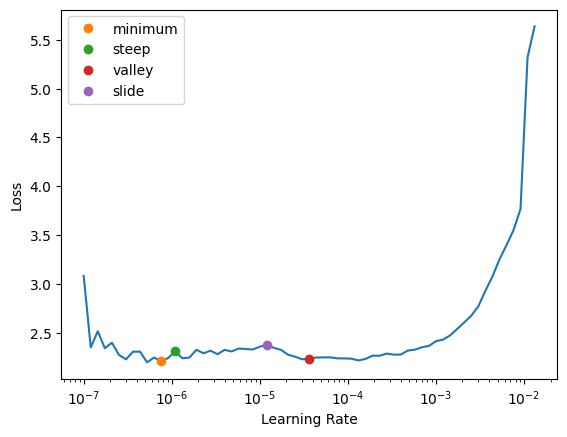

In [19]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [20]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 4e-5), cbs=fit_cbs)

epoch,train_loss,valid_loss,time
0,2.223471,2.068742,05:36
1,1.764895,2.087800,05:15
2,1.299264,2.206854,05:20


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3635: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

# Inference

In [21]:
inf_learn = load_learner(fname="news_summarizer.pkl")

In [22]:
prediction = inf_learn.blurr_generate("random placeholder")
prediction[0]['generated_texts']

" random placeholder is a random placeholder for the next few days . It will be used as a placeholder for an unknown reason . It's unclear if the placeholder is actually a real name or a real person, or if it's a real identity .\nThe first time the placeholder has been used in this way, it's unclear whether it's an official ."

# Utilizing, Training, Finetuning LLMs with OpenAI
Check out the OpenAI API and their documentations here: https://openai.com/api/